# Case Study- Real Estate Pricing

### Preloading Modules and Functions

In [5]:
# Pandas is for using data structures
import pandas as pd
# statsmodels contain modules for regression and time series analysis
import statsmodels.api as sm
# numpy is for numerical computing of array and matrix
import numpy as np
# Matplotlib is a plotting package
import matplotlib.pyplot as plt
# matplotlib Showing the plot right after the current code  
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# basic statistics package
import scipy.stats as stats
# Calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor


#### Adj_R2_antilog(model):
#### Transform the response (log(y)) back to the original form (y), then compute the adjusted R2
- Input:
    - model: a fitted regression model that the response is applied with a log transformation

- Output:
    - Adjusted Rsquare in original scale of y

In [6]:
def Adj_R2_antilog(model):

    Y = np.exp(model.model.endog)
    n = len(Y)
    p_prime = len(model.params)
    SSE = np.sum((Y-np.exp(model.fittedvalues))**2)
    SST = np.sum((Y-np.mean(Y))**2)
    df_SSE = n-p_prime
    df_SST = n-1

    R2 = 1-(SSE/df_SSE)/(SST/df_SST)
    return R2

In [7]:
# functions from last lab
def four_in_one(dataframe,model):
    fitted_y = model.fittedvalues
    studentized_residuals = model.get_influence().resid_studentized_internal
    plt.figure(figsize=(10,10))
    ax1 = plt.subplot(221)
    QQ=stats.probplot(studentized_residuals, dist="norm", plot=plt)
    ax1.set_title('Normal Q-Q')
    ax1.set_xlabel('Normal Quantiles')
    ax1.set_ylabel('Studentized Residuals');
    
    # annotations for the top 3 residulas (if their absolute values are larger than 2)
    stdRes_id = np.flip(np.argsort(np.abs(studentized_residuals)), 0)
    if abs(stdRes_id[0])>2:
        stdRes_top_3_id = stdRes_id[:3]
        abs_norm_resid = np.flip(np.argsort(np.abs(QQ[0][1])), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax1.annotate(stdRes_top_3_id[r],
                                       xy=(QQ[0][0][i],
                                           QQ[0][1][i]));

    ax2 = plt.subplot(222)
    ax2.hist(studentized_residuals)
    ax2.set_xlabel('Studentized Residuals')
    ax2.set_ylabel('Count')
    ax2.set_title('Histogram')

    ax3 = plt.subplot(223)
    t = range(dataframe.shape[0])
    ax3.scatter(t, studentized_residuals)
    ax3.set_xlabel('Observation order')
    ax3.set_ylabel('Studentized Residuals')
    ax3.set_title('Time series plot of studentized residuals')

    ax4 = plt.subplot(224)
    ax4 = sns.residplot(fitted_y, studentized_residuals,
                              lowess=True,
                              scatter_kws={'alpha': 0.5},
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    ax4.set_title('Studentized Residuals vs Fitted values')
    ax4.set_xlabel('Fitted values')
    ax4.set_ylabel('Studentized Residuals');
    
def getvif(X):
    X = sm.add_constant(X)
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["Predictors"] = X.columns
    return(vif.drop(index = 0).round(2)) 

def prediction(new_X,model):
    return(model.get_prediction(new_X).summary_frame())

## Loading data

In [8]:
# Impport data
df = pd.read_excel('data/Real estate valuation data set.xlsx')
df = df.drop(columns='No')
N = df.shape
print(N)

(414, 7)


## Exploratory Data Analysis

In [9]:
#Step 1: Exploratory Data Analysis
#Summary statistics
print(df.describe())

       transactionDate    houseAge  distanceToMRT  numberOfStores         lat  \
count       414.000000  414.000000     414.000000      414.000000  414.000000   
mean       2013.148953   17.712560    1083.885689        4.094203   24.969030   
std           0.281995   11.392485    1262.109595        2.945562    0.012410   
min        2012.666667    0.000000      23.382840        0.000000   24.932070   
25%        2012.916667    9.025000     289.324800        1.000000   24.963000   
50%        2013.166667   16.100000     492.231300        4.000000   24.971100   
75%        2013.416667   28.150000    1454.279000        6.000000   24.977455   
max        2013.583333   43.800000    6488.021000       10.000000   25.014590   

             long  pricePerUnitArea  
count  414.000000        414.000000  
mean   121.533361         37.980193  
std      0.015347         13.606488  
min    121.473530          7.600000  
25%    121.528085         27.700000  
50%    121.538630         38.450000  
75% 

In [10]:
df.corr()

,transactionDate,houseAge,distanceToMRT,numberOfStores,lat,long,pricePerUnitArea
transactionDate,1.000000,0.017542,0.060880,0.009544,0.035016,-0.041065,0.087529
houseAge,0.017542,1.000000,0.025622,0.049593,0.054420,-0.048520,-0.210567
distanceToMRT,0.060880,0.025622,1.000000,-0.602519,-0.591067,-0.806317,-0.673613
numberOfStores,0.009544,0.049593,-0.602519,1.000000,0.444143,0.449099,0.571005
lat,0.035016,0.054420,-0.591067,0.444143,1.000000,0.412924,0.546307
long,-0.041065,-0.048520,-0.806317,0.449099,0.412924,1.000000,0.523287
pricePerUnitArea,0.087529,-0.210567,-0.673613,0.571005,0.546307,0.523287,1.000000


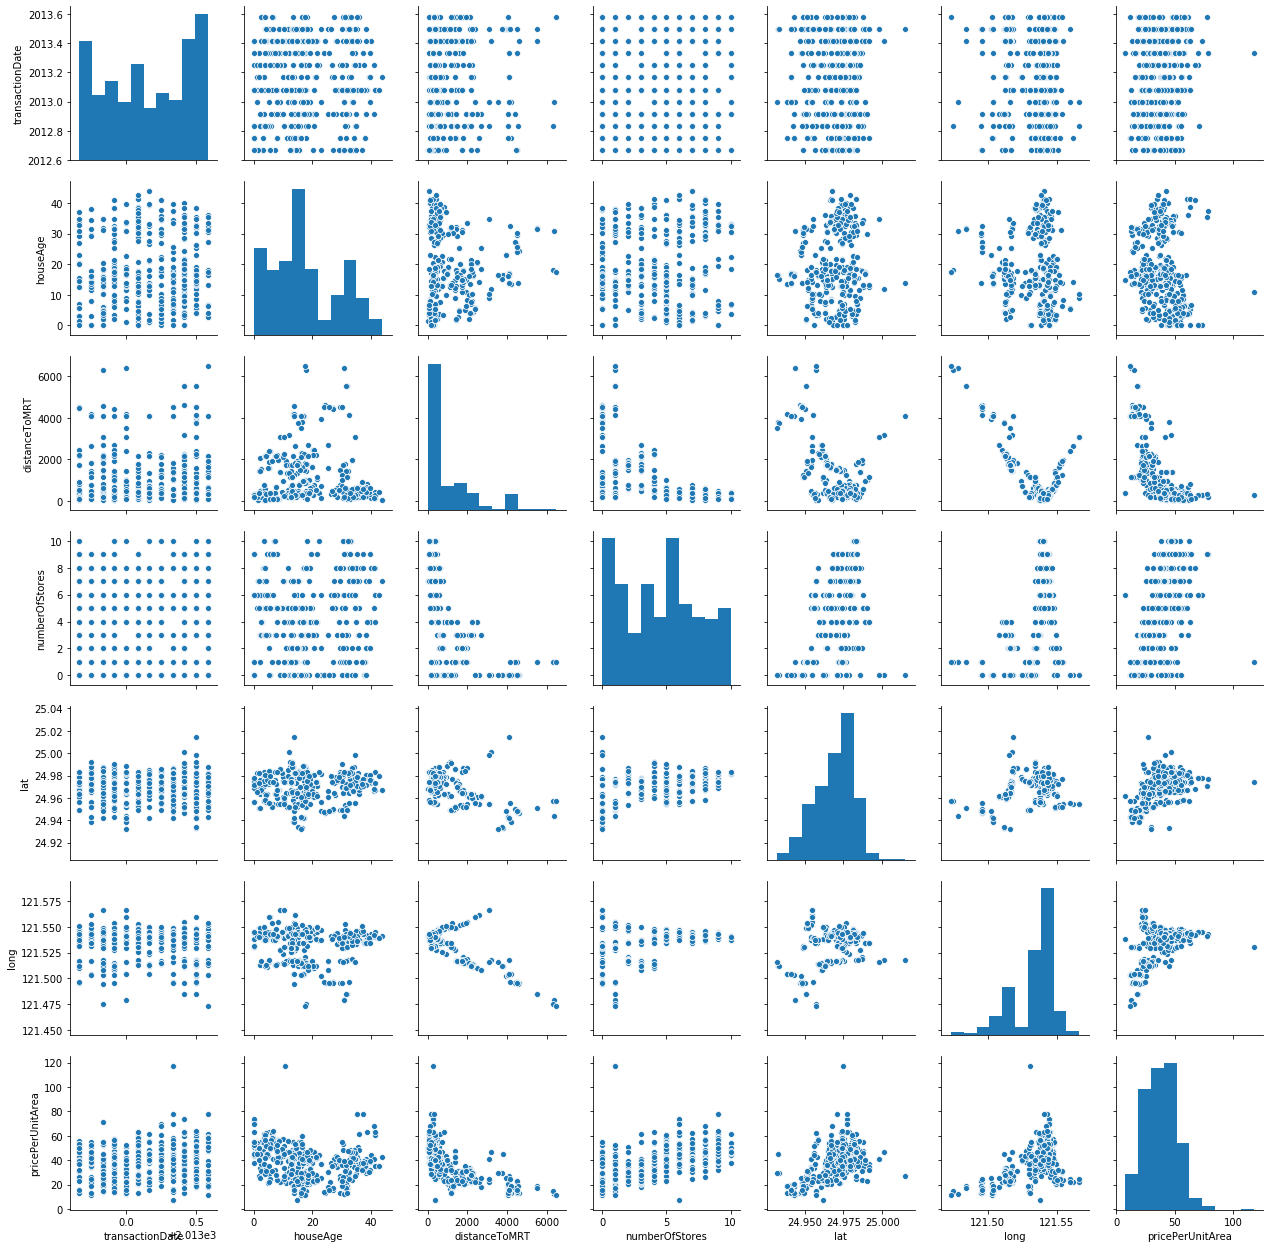

In [11]:
#Scatterplot matrix
import seaborn as sns 
sns.pairplot(df)

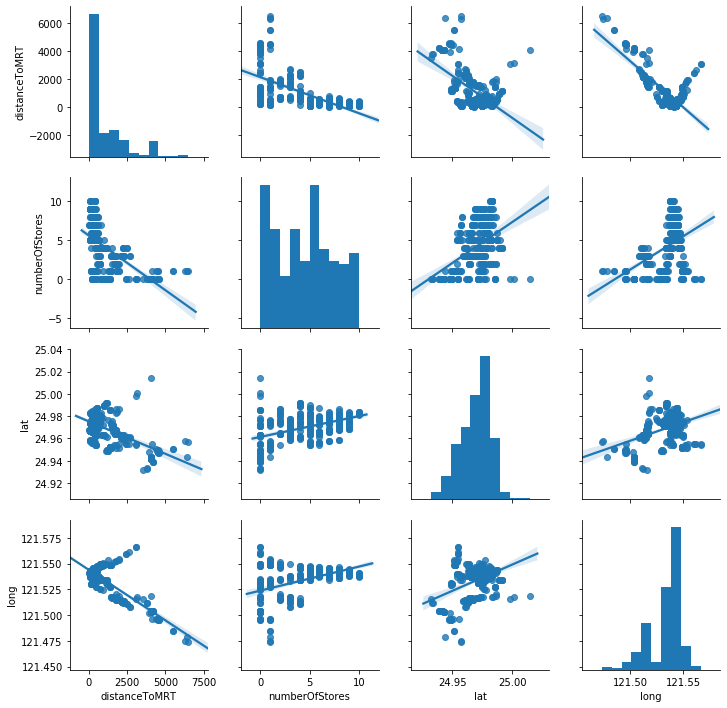

In [12]:
#Scatterplot matrix
sns.pairplot(df.iloc[:,2:6],kind='reg') #"kind='reg'" generates a regression line for each scatter plot

In [13]:
#VIF
X=df.drop(columns='pricePerUnitArea')
getvif(X)

,VIF,Predictors
1,1.01,transactionDate
2,1.01,houseAge
3,4.32,distanceToMRT
4,1.62,numberOfStores
5,1.61,lat
6,2.93,long


# Model 1 -  full model

In [14]:
import statsmodels.api as sm

X = df.drop(columns='pricePerUnitArea')
Y = df['pricePerUnitArea']

model_fit = sm.OLS(Y,sm.add_constant(X)).fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       pricePerUnitArea   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     94.60
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           4.83e-74
Time:                        12:56:19   Log-Likelihood:                -1487.0
No. Observations:                 414   AIC:                             2988.
Df Residuals:                     407   BIC:                             3016.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.444e+04   6775.386     -2.132      0.034   -2.78e+04   -1122.863
transactionDate     5.1490      1.557      3.307      0.001       2.088       8.210
houseAge           -0.2697      0.039     -7.000      0.000      -0.345      -0.194
distanceToMRT      -0.0045      0.001     -6.250      0.000      -0.006      -0.003
numberOfStores      1.1333      0.188      6.023      0.000       0.763       1.503
lat               225.4701     44.566      5.059      0.000     137.862     313.078
long              -12.4291     48.581     -0.256      0.798    -107.930      83.072
==============================================================================
Omnibus:                      231.615   Durbin-Watson:                   2.153
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3598.692
Skew:                           2.026   Prob(JB):                         0.00
Kurtosis:                      16.864   Cond. No.                     3.72e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

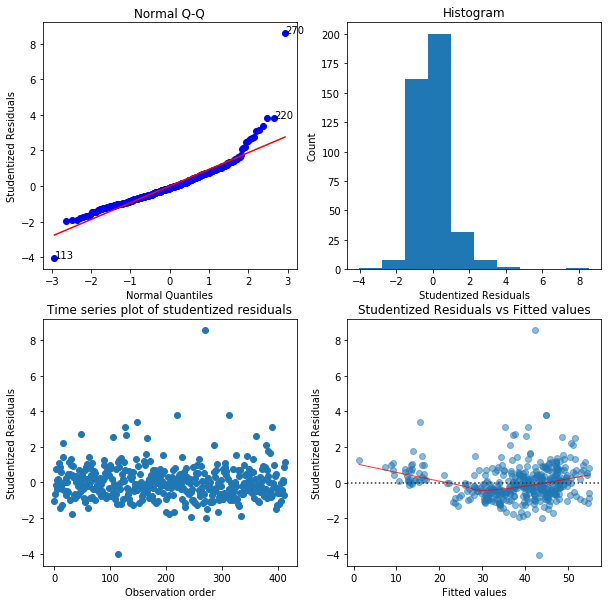

In [15]:
# residuals plots
four_in_one(df,model_fit)

## Model 2 - Transformation 

## Visualization - Relationship between distanceToMRT and price:


Text(0.5, 0, 'log(distanceToMRT)')

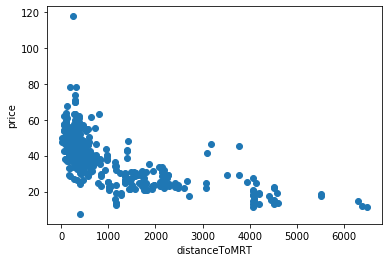

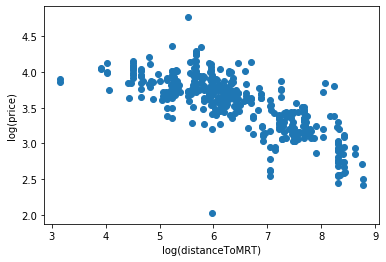

In [16]:
# Visualization - Relationship between distanceToMRT and price:

# Price vs distanceToMRT
plt.scatter(X['distanceToMRT'],Y)
plt.ylabel('price')
plt.xlabel('distanceToMRT')

# log(Price) vs log(distanceToMRT)
plt.figure()
plt.scatter(np.log(X['distanceToMRT']),np.log(Y))
plt.ylabel('log(price)')
plt.xlabel('log(distanceToMRT)')


### Transofrmation: log(Price), log(distanceToMRT)

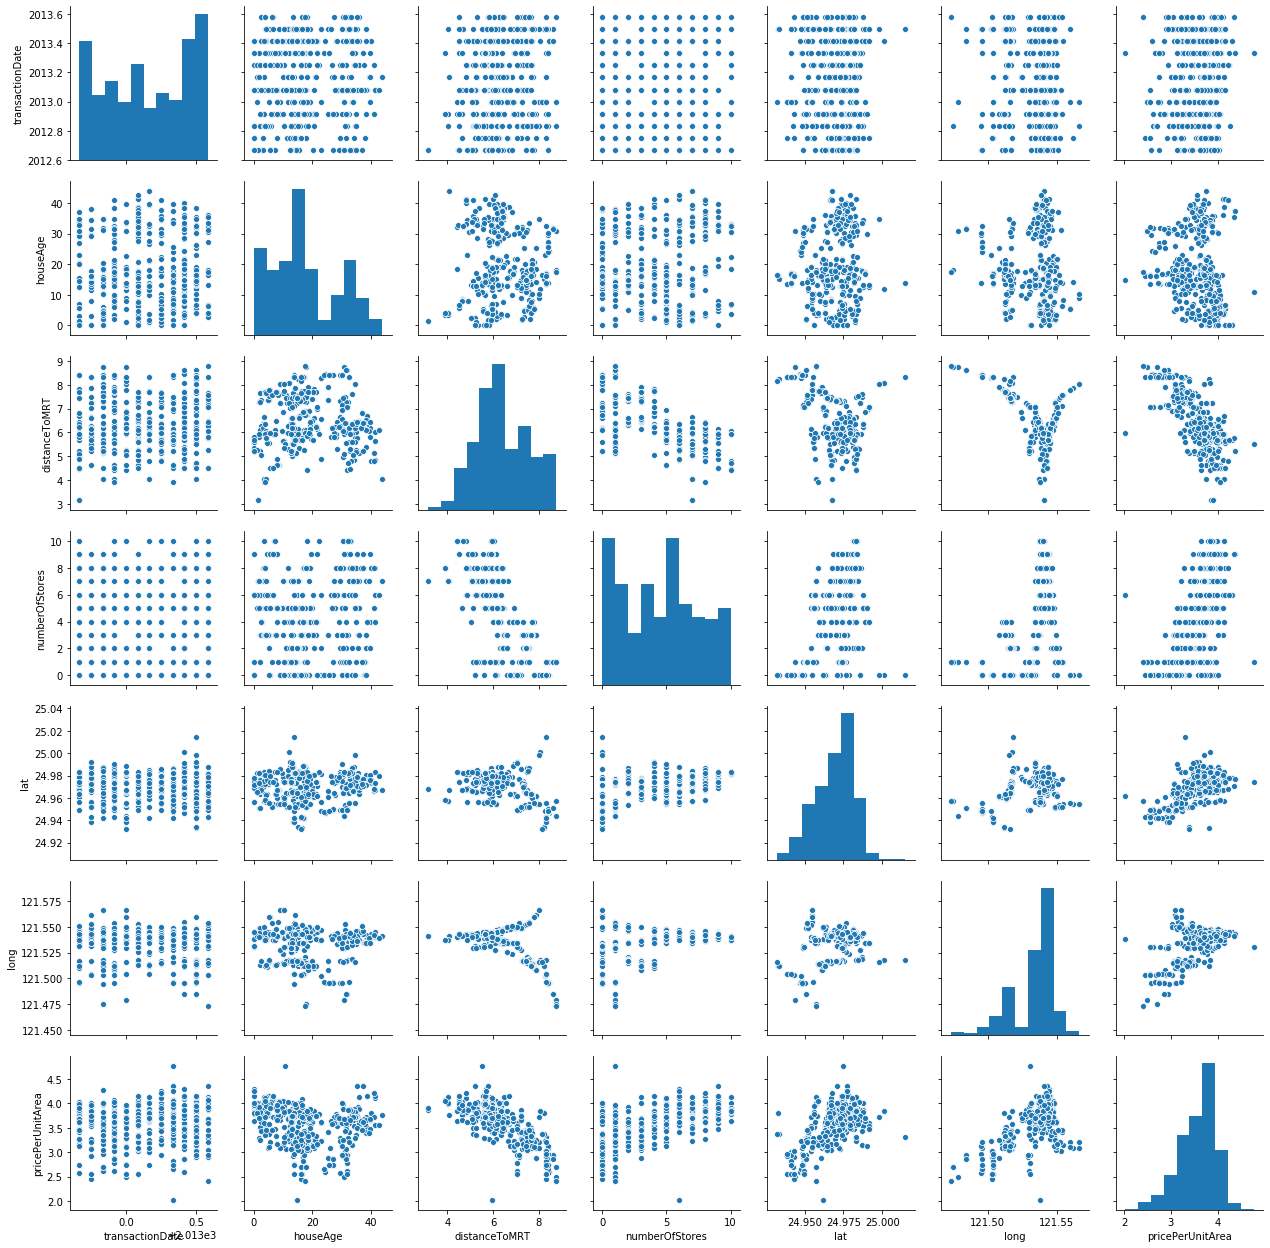

In [17]:
X2 = df.drop(columns='pricePerUnitArea')
Y2 = df['pricePerUnitArea']

#Transformations of the predictors
X2['distanceToMRT'] = np.log(X2['distanceToMRT'])
#Transformation of the response
Y2 = np.log(Y2)

# Scatter plot matrix after transformation
df2 = pd.concat([X2, Y2], axis=1)
sns.pairplot(df2)

In [18]:
#Fitting model 2
model_fit = sm.OLS(Y2,sm.add_constant(X2)).fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:       pricePerUnitArea   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     177.9
Date:                Wed, 21 Oct 2020   Prob (F-statistic):          1.92e-110
Time:                        12:56:34   Log-Likelihood:                 66.715
No. Observations:                 414   AIC:                            -119.4
Df Residuals:                     407   BIC:                            -91.25
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -899.9215    127.813     

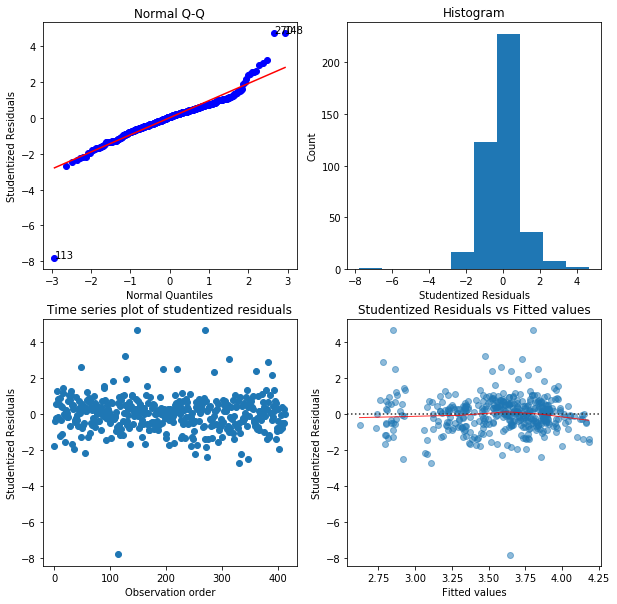

In [19]:
# residuals plots
four_in_one(df2,model_fit)

In [20]:
#Calculate the adjusted R-squared of model 2 to be comparable with model 1 (such that the responses are the same)
Adj_R2_antilog(model_fit)

0.6445037368163135

## Model 3 -  Indicator variable and interaction term

In [21]:
X = df.drop(columns="pricePerUnitArea")
Y = df["pricePerUnitArea"]

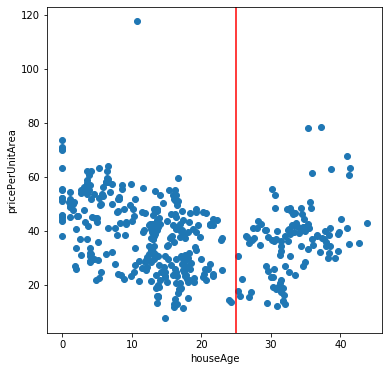

In [22]:
#houseAge vs price
plt.figure(figsize=[6,6])
plt.scatter(X["houseAge"],Y)
plt.xlabel("houseAge")
plt.ylabel("pricePerUnitArea")
# adding a vertical line
plt.axvline(x=25,c="red")

### Create indicator for 'newHouse' and interaction between 'newHouse' and 'houseAge'

In [23]:
df3 = df.copy()
# Indicator for 'newHouse'
df3["newHouse"] = (df3["houseAge"] <= 25)*1
# interaction between 'newHouse' and 'houseAge'
df3["newHouse_houseAge"] = df3["newHouse"]*df3["houseAge"]
df3.head(10)

,transactionDate,houseAge,distanceToMRT,numberOfStores,lat,long,pricePerUnitArea,newHouse,newHouse_houseAge
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9,0,0.0
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2,1,19.5
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3,1,13.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8,1,13.3
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1,1,5.0
5,2012.666667,7.1,2175.03000,3,24.96305,121.51254,32.1,1,7.1
6,2012.666667,34.5,623.47310,7,24.97933,121.53642,40.3,0,0.0
7,2013.416667,20.3,287.60250,6,24.98042,121.54228,46.7,1,20.3
8,2013.500000,31.7,5512.03800,1,24.95095,121.48458,18.8,0,0.0
9,2013.416667,17.9,1783.18000,3,24.96731,121.51486,22.1,1,17.9


In [24]:
# creating X,Y for model 3
X = df3.drop(columns="pricePerUnitArea")
Y = df3["pricePerUnitArea"]
# Log transform of 'distanceToMRT'
X["distanceToMRT"] = np.log(X["distanceToMRT"])
# Change the variable's name: 'distanceToMRT' to 'log(distanceToMRT)'
X.rename(columns={"distanceToMRT":"log(distanceToMRT)"}, inplace=True)


In [25]:
# fitting model 3
model_fit = sm.OLS(Y,sm.add_constant(X)).fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:       pricePerUnitArea   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     103.2
Date:                Wed, 21 Oct 2020   Prob (F-statistic):           7.80e-93
Time:                        12:56:36   Log-Likelihood:                -1437.6
No. Observations:                 414   AIC:                             2893.
Df Residuals:                     405   BIC:                             2930.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -2.19e+04   4875

In [26]:
# VIF (without the interaction term)
getvif(X.drop(columns='newHouse_houseAge'))

,VIF,Predictors
1,1.03,transactionDate
2,4.17,houseAge
3,2.80,log(distanceToMRT)
4,2.02,numberOfStores
5,1.37,lat
6,1.79,long
7,4.18,newHouse


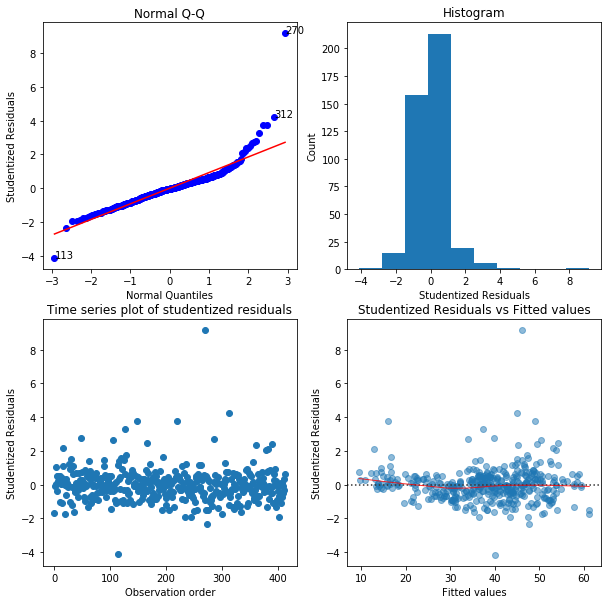

In [27]:
# Residuals plots
four_in_one(df3,model_fit)

In [28]:
#Prediction with model 3
XNew = [1,2013,16,np.log(100),5,24.98,121.54,1,1*16]
YNew = model_fit.predict(XNew)
YNew

array([50.12957647])

In [29]:
# Prediction, CI, PI
prediction(XNew,model_fit)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,50.129576,1.146669,47.875411,52.383742,34.471341,65.787812
